# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [55]:
# Load pickled data
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# TODO: fill this in based on where you saved the training and testing data
training_file = "train.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [56]:
n_train = X_train.shape[0]
n_test = X_test.shape[0]
image_shape = X_train.shape[1:]
n_classes = len(set(np.hstack((y_train, y_test))))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


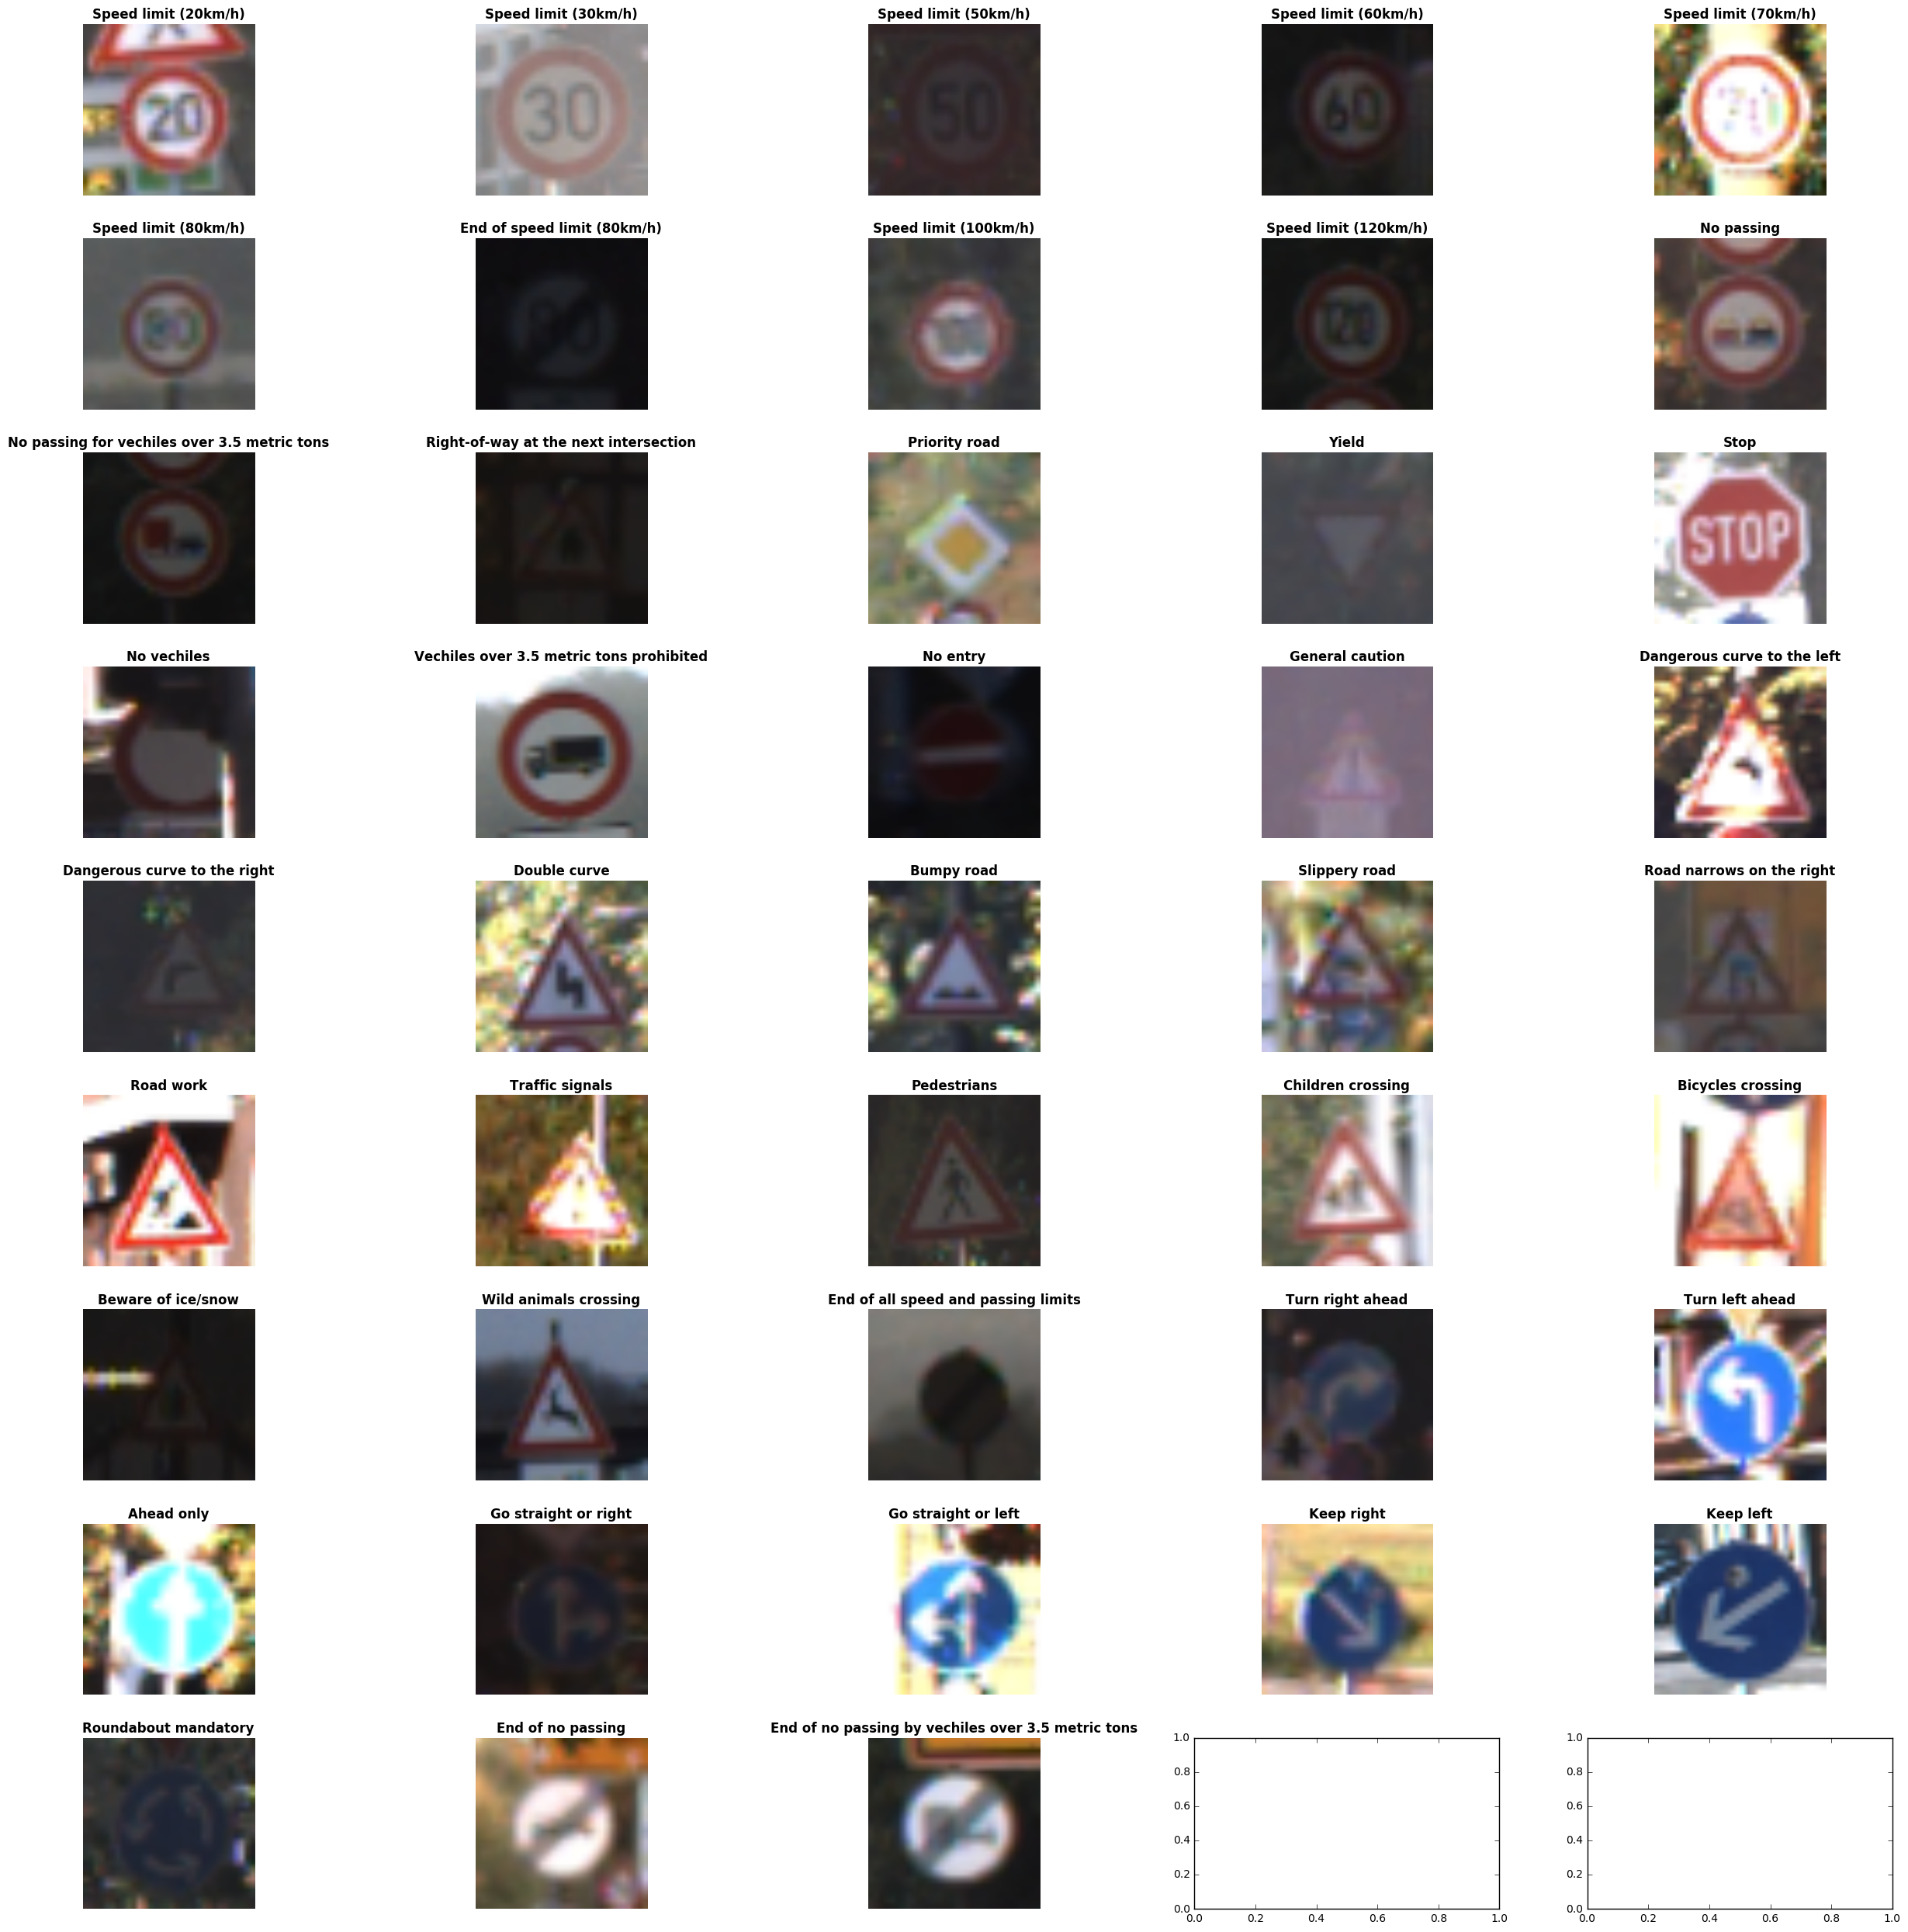

In [57]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
%matplotlib inline

# Read traffic sign class name information.
sig_names = pd.read_csv('signnames.csv')

# Loop over traffic sign classes and display them in 5*n grid.
_, ax = plt.subplots(9,5,figsize=(25,25))
row_counter = 0
for class_id, sign_name in zip(sig_names.ClassId, sig_names.SignName):
    idx = np.where(y_train == class_id)[0][np.random.randint(0, 10)]
    # After every 5 images start a new row of images.
    if class_id % 5 == 0 and class_id > 0:
        row_counter += 1
    ax[row_counter, class_id % 5].imshow(X_train[idx])
    ax[row_counter, class_id % 5].set_title(sign_name, fontdict={'fontweight': 'bold'})
    ax[row_counter, class_id % 5].grid(False)
    ax[row_counter, class_id % 5].axis('off')
plt.tight_layout()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [58]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

In [59]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import resample

## Convert images to gray scale   
def color_to_grey_image(
    image, 
    use_channel=True,
    norm_type = 0):
    g_image = np.mean(image, axis = -1)
    if norm_type == 0:
        g_image = (g_image - (255 / 2.0)) / 255
    
    if use_channel:
        ret_image = np.zeros(
            (image.shape[0], image.shape[1], 1),
            dtype = np.float32)
        ret_image[:,:,0] = g_image
    else:
        ret_image = g_image
    return ret_image
    
def color_to_grey_images(
    images,
    use_channel=True,
    norm_type = 0):
    inum = len(images)
    ishape = images[0].shape
    g_images = np.zeros((inum, ishape[0], ishape[1], 1),
                        dtype = np.float32)
    for n in range(inum):
        g_images[n] = color_to_grey_image(
            images[n], use_channel=use_channel, norm_type=norm_type)
    return g_images

In [60]:
## Convert images from color to grey scale and normalize them
X_train_grey = color_to_grey_images(X_train)
X_test_grey = color_to_grey_images(X_test)

In [61]:
### one hot coding Y
def to_categorical(y, nb_classes=n_classes):
    '''Convert class vector (integers from 0 to nb_classes) to binary class matrix, for use with categorical_crossentropy.
    # Arguments
        y: class vector to be converted into a matrix
        nb_classes: total number of classes
    # Returns
        A binary matrix representation of the input.
    '''
    if not nb_classes:
        nb_classes = np.max(y)+1
    Y = np.zeros((len(y), nb_classes))
    for i in range(len(y)):
        Y[i, y[i]] = 1.
    return Y

Y_train = to_categorical(y_train)
Y_test  = to_categorical(y_test)

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

I used the following techniques to preprocess the data:
1. Convert images to gray scale
2. Normalize images from [0,255] to [-0.5,0.5]
3. Convert y_train, y_test to one hot coding format

Since the color of the picutre can be very different due to different lighting condition and color bias, I decided to just use the gray scale images for training the model in order to handle more possible cases by focusing on the average value instead of values on each RGB channel.  As mentioned in the class, it would take a much longer time to train the model till converge if the data is not centered by origin point with same scale.  So I normalized the images before training.  In order to apply cross entropy related as loss function to assess the performance of the model in the outcome classification variable, one hot coding on y was used.

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

- Randomly split training data into 80/20% of training and validation set. The testing data used is the one provided.  So the total split is training:validation:testing = 60%:15%:25%.

- I have not generated any additional data at this time.  Extracting some of the edge and histogram features might be helpful to make the model more robust.  

In [62]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

In [63]:
from sklearn.cross_validation import train_test_split

## Split data into training and validation
def get_train_validation_set(X = X_train_grey,y = Y_train,train_size = 0.8):
    """
    Split data into training and validation
    """
    data_train, data_test, labels_train, labels_test =train_test_split(X, y, train_size=train_size, random_state=12)
    
    return data_train, data_test, labels_train, labels_test


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

I gathered ideas from https://classroom.udacity.com/nanodegrees/nd013, http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf,https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/convolutional_network.py,  https://github.com/kunfengchen/carnd-p2/blob/master/Traffic_Signs_Recognition.ipynb, https://www.tensorflow.org/versions/r0.11/tutorials/mnist/beginners/index.html to gather ideas about the design of the convolution nerual network structure.

For this project, I only tried two design of nerual network.  First I went with 1-convolution-layer structure, the accruacy is not good enough, so I went with 2-convolution-layer with ReLU, max pooling and additional fully connected layers with dropout.



The final architechture:
1. Input Layer (input: 32 X 32 X 1)
2. First Convolutional Layer
  - convolution [5, 5, 1, 32]
  - ReLU
  - max pooling 2x2
3. Second Convolutional Layer
    - convolution [5, 5, 32, 64]
    - ReLU
    - max pooling 2x2
4. Fully Connected Layer 1
    - 2048 neurons
    - ReLU
    - Dropout 
5. Fully Connected Layer 2 （output: 1 X 43）

In [130]:
# Create a new interactive session in subsequent code cells.
import tensorflow as tf

config = tf.ConfigProto()
sess = tf.InteractiveSession(config=config)

sess.as_default()

In [82]:
# define hyperparamter and input
n_channels = 1 
n_classes = Y_train.shape[1]
x = tf.placeholder(tf.float32,[None, image_shape[0], image_shape[1], n_channels])
y_ = tf.placeholder(tf.float32, [None, n_classes])

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# Convolution and Pooling layer func
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

## 1st Convolutional Layer
# weight tensor shape is  [ patch width, patch height, num of input channels, output channels]
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

# reshape to a 4d tensor [num of images, image width, image height, color channels]
x_image = x

# convolve x_image with weight tensor, add the bias, apply ReLu function, and max pool
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

## 2nd Convolutional Layer
# 32 input features, 64 output feature for each 5x5 patch
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

n_neurons = 2048

## Densely Connected Layer

W_fc1 = weight_variable([8 * 8 * 64, n_neurons])
b_fc1 = bias_variable([n_neurons])

h_pool2_flat = tf.reshape(h_pool2, [-1, 8 * 8 *64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

## Dropout
# To reduce overfitting

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

## Readout Layer
W_fc2 = weight_variable([n_neurons, n_classes])
b_fc2 = bias_variable([n_classes])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

print ('y_ = {}'.format(y_conv))
print ('y_conv = {}'.format(y_conv))
print ('h_pool2 = {}'.format(h_pool2))
print ('W_fc1 shape = {}'.format(W_fc1.get_shape()))
print ('W_fc2 shape = {}'.format(W_fc2.get_shape()))

y_ = Tensor("add_26:0", shape=(?, 43), dtype=float32)
y_conv = Tensor("add_26:0", shape=(?, 43), dtype=float32)
h_pool2 = Tensor("MaxPool_13:0", shape=(?, 8, 8, 64), dtype=float32)
W_fc1 shape = (4096, 2048)
W_fc2 shape = (2048, 43)


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

To train the model, I used an AdamOptimizer to adaptively learn and opitmize weights in terms of loss function.
Using the validation set, I experimented with the number of convolutional layers, the number of fully-connected layers, and the dropout probability.  

As for hyperparameter selection, I tried batch size 1,50, 200, 500.  I choose the batch size of 200 for training in the end since it is kind of balance of performance and computation cost.  As for epoches, the compuatation time is relatively long if I go beyond 10,000, I chose 5000 since it generate around 0.9 accruacy with no more than 40 minutes, which allow me to play around other parameters to see how the model performance differs.   



The detailed information is listed as follows:
- optimizer: AdamOptimizer
- batch size: 200
- epochs: 5000 steps
- 80% training data and 20% validation data 

In [83]:
## Train the Model
X_train_set = X_train_grey
X_test_set = X_test_grey

cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(y_conv, y_))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

sess.run(tf.initialize_all_variables())

In [84]:
%matplotlib inline
### Train data
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
def show_images(images=X_train, size=30, skips=103):
    n_images = len(images)
    gs1 = gridspec.GridSpec(3, 10)
    gs1.update(wspace=0.1, hspace=0.1)
    plt.figure(figsize=(12, 3))
    for i in range(size):
        ax1 = plt.subplot(gs1[i])
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        image = images[(i*skips) % n_images]
        # plt.subplot(3, 10,i+1)
        if image.shape[2] == 1: # grey
            image = image[:, :, 0]
            # print (image.shape)
        plt.imshow(image, cmap=plt.cm.Greys) # for grey images in grey
        plt.axis('off')
    plt.show()

In [85]:
# define general training function
def do_train(steps = 5000,
               batch_size = 200,
               X_train_set = X_train_set,
               Y_train = Y_train,
               X_validation_set = None,
               Y_validation = None,
               X_test_set = X_test_set,
               Y_test = Y_test):
    """ Do the training """
    train_size = Y_train.shape[0]
    for step in range(steps):
        # offset = (step * batch_size) % (train_size - batch_size)
        offset = (step * batch_size) % train_size
        batch_train_data = X_train_set[offset:(offset + batch_size), :, :, :]
        batch_train_labels = Y_train[offset:(offset + batch_size)]
        if step % 200 == 0:
            train_accuracy = accuracy.eval(feed_dict={
                x:batch_train_data, y_: batch_train_labels, keep_prob: 1.0})
            print("step %d, training accuracy %g"%(step, train_accuracy))
        train_step.run(
            feed_dict={x: batch_train_data, 
                       y_: batch_train_labels, keep_prob: 0.5})
        if step % 500 == 0:
            if X_validation_set != None:
                print("validation accuracy %g"%accuracy.eval(feed_dict={
                x: X_validation_set, y_: Y_validation, keep_prob: 1.0}))
    print("test accuracy %g"%accuracy.eval(feed_dict={x: X_test_set, y_: Y_test, keep_prob: 1.0}))

In [86]:
# Model input check
print (y_train)
print (y_test)
print (Y_train.shape)
print (Y_train[123])
#print (Y_train)
print (Y_train.dtype)
print (Y_test[10])
print(X_train_set.shape)
print(X_train_set[10])

[ 0  0  0 ..., 42 42 42]
[16  1 38 ...,  6  7 10]
(31367, 43)
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.]
float64
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.]
(39209, 32, 32, 1)
[[[-0.01503268]
  [ 0.01895425]
  [-0.10915033]
  ..., 
  [-0.08692811]
  [-0.10261438]
  [-0.18104576]]

 [[ 0.0503268 ]
  [-0.07777778]
  [-0.11830065]
  ..., 
  [-0.07385621]
  [-0.05424837]
  [-0.17058824]]

 [[-0.00196078]
  [-0.1379085 ]
  [-0.1       ]
  ..., 
  [-0.09477124]
  [-0.04640523]
  [-0.18104576]]

 ..., 
 [[-0.0124183 ]
  [-0.00196078]
  [ 0.00065359]
  ..., 
  [-0.23333333]
  [-0.21764706]
  [-0.19934641]]

 [[-0.05947712]
  [ 0.17843138]
  [ 0.17450981]
  ..., 
  [-0.22287582]
  [-0.23333333]
  [-0.21764706]]

 [[-0.09869281]
  [ 0.

In [87]:
## Actual training
import time

X_train_set, X_validation_set, Y_train, Y_validation = get_train_validation_set()
    
print (X_train_set.shape)
print (Y_train.shape)
print (X_validation_set.shape)
print (Y_validation.shape)

starttime = time.clock()
do_train(steps=5000,
         batch_size = 200,
         X_train_set = X_train_set,
         Y_train = Y_train,
         X_validation_set = X_validation_set,
         Y_validation = Y_validation)
endtime = time.clock()

print('Training took {:.2f} seconds'.format(endtime - starttime))

(31367, 32, 32, 1)
(31367, 43)
(7842, 32, 32, 1)
(7842, 43)
step 0, training accuracy 0.03


/Users/codehi/Documents/software/Anaconda/anaconda/envs/IntroToTensorFlow/lib/python3.5/site-packages/ipykernel/__main__.py:24: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


validation accuracy 0.0402958
step 200, training accuracy 0.535
step 400, training accuracy 0.66
validation accuracy 0.754144
step 600, training accuracy 0.745
step 800, training accuracy 0.87
step 1000, training accuracy 0.895
validation accuracy 0.8772
step 1200, training accuracy 0.93
step 1400, training accuracy 0.95
validation accuracy 0.93114
step 1600, training accuracy 0.955
step 1800, training accuracy 0.975
step 2000, training accuracy 0.965
validation accuracy 0.952946
step 2200, training accuracy 0.97
step 2400, training accuracy 0.985
validation accuracy 0.970033
step 2600, training accuracy 0.985
step 2800, training accuracy 0.985
step 3000, training accuracy 0.985
validation accuracy 0.971436
step 3200, training accuracy 1
step 3400, training accuracy 0.99
validation accuracy 0.975644
step 3600, training accuracy 0.98
step 3800, training accuracy 0.995
step 4000, training accuracy 0.99
validation accuracy 0.975644
step 4200, training accuracy 0.99
step 4400, training acc

In [90]:
# Save the model
saver = tf.train.Saver()
saver.save(sess, "model.ckpt")

'model.ckpt'

In [91]:
# Evaluate accuracy on test dataset
test_accuracy = accuracy.eval(feed_dict={x:X_test_set, y_: Y_test, keep_prob: 1.0})
print('Test Accuracy: %f' % test_accuracy)

Test Accuracy: 0.889707


### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**
I took the following steps to come up with a solution to this problem:
1. Gathered ideas from the CarND class material and its references. There are also some good materials online.
2. Tried to use two-layer convolutinal structure from TenserFlow MNIST example and 80% training 20% validatation data split,  and got a test accuracy around 0.88 in 5,000 steps.
3. Added drop out layer to get a better result, more modifications could be done to achieve better performance

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [3]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

In [96]:
import os
print(os.getcwd())

/Users/codehi/Projects/traffic-signs


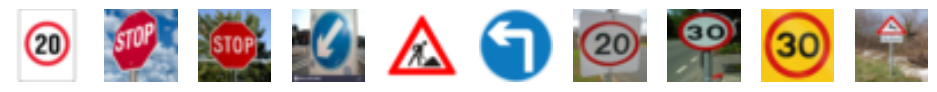

[[ 1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
   0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
   0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000  0.000
   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
   0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
   0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000  0.000
   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
   0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000

In [105]:
from scipy import misc
import glob

n_images = 10
new_images = []

# load new images
for i in range(1,n_images+1):
    ifile = 'web_images/sign{}.jpg'.format(i)
    im = misc.imread(ifile)[:, :, :3]
    im = misc.imresize(im, (32, 32))
    # print (im.shape)
    new_images.append(im)

#plt.imshow(images[0])
show_images(images=new_images, size=len(new_images), skips=1)
new_test_labels = [0, 14, 14, 38, 25, 34, 0,1,1,31]
X_test_new_set = color_to_grey_images(new_images)


Y_test_new = to_categorical(new_test_labels)
print (Y_test_new)


In [118]:
## Use new images for prediction
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
predict_layer = y_conv.eval(feed_dict={
        x: X_test_new_set, y_: Y_test_new, keep_prob: 1.0})
predict_sm = tf.nn.softmax(pre_layer).eval()
label_sm = y_.eval(feed_dict={
        x: X_test_new_set, y_: Y_test_new, keep_prob: 1.0})
predict = np.argmax(predict_sm, 1)
label = np.argmax(label_sm, 1)
print ("Predicted Labels: ",predict)
print ("True Labels: ", label)
correct_predict = np.equal(predict, label)
print ('Correct Prediction Result: ', correct_predict)
print ('Acuracy: ', np.mean(cor_predict.astype(np.float32)))

Predicted Labels:  [ 0 34 14 28 25 34  0 33  1 10]
True Labels:  [ 0 14 14 38 25 34  0  1  1 31]
Correct Prediction Result:  [ True False  True False  True  True  True False  True False]
Acuracy:  0.6


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**
Based on the observation on the misclassified traffic sign images on the newly captured images, I find the following qualities that might make the classification difficult:
- Image is rotated
- Traffic sign is too small
- Traffic sign is not in the center of the image
- Complicated background

In [4]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

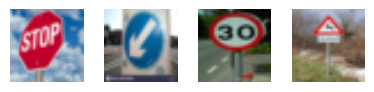

In [124]:
# incorrectly predict images
false_images=np.array(new_images)[~correct_predict]
show_images(images=false_images, size=len(false_images), skips=1)

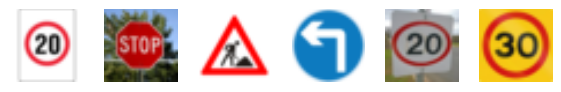

In [127]:
#correctly predicted images
true_images=np.array(new_images)[correct_predict]
show_images(images=true_images, size=len(true_images), skips=1)

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**
My model perform a little bit worse in the testing set, but the accruacy(0.6) on newly captured images is 
significantly lower than the testing accruacy(0.88). 

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**
In my testing case of 10 newly captured images, top 5 prediction did produce a higher accruacy since it failed to include true lable in the top 5 list.  The lack of enough samples and sufficient training may be the reasons casuing 
poor performance of top 5 prediction.

In order to visualize the softmax probabilities, I created line plot for each of the predicted categories and corresponding probabilities.  As you can see, the model has high certainty since the probability for the most likely outcome is more than 0.7 in all shown cases.  However, it would be problematic if if the model prediction is biased, where the model is kind of certainly produce wrong prediction in some cases.  

In [129]:
#print out top 5 prediction result
values, indices = tf.nn.top_k(predict_sm, k=5)
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
print ('Top 5 guess:  \n', values.eval())
print ('Top 5 predict: \n', indices.eval())
print ('Predict: ', pre)
print ('Label  : ', lab)
cor_pre = np.equal(pre, lab)
print ('Predictions: ', cor_pre)

Top 5 guess:  
 [[ 0.977  0.021  0.001  0.000  0.000]
 [ 0.895  0.056  0.019  0.014  0.005]
 [ 1.000  0.000  0.000  0.000  0.000]
 [ 0.737  0.128  0.118  0.009  0.003]
 [ 1.000  0.000  0.000  0.000  0.000]
 [ 0.646  0.274  0.064  0.008  0.004]
 [ 0.999  0.001  0.000  0.000  0.000]
 [ 0.722  0.217  0.057  0.002  0.001]
 [ 0.979  0.013  0.003  0.003  0.001]
 [ 0.655  0.292  0.028  0.021  0.003]]
Top 5 predict: 
 [[ 0  4  1 16  7]
 [34 41 28 12  0]
 [14 17 13 34 38]
 [28 22 29 14  1]
 [25 30 20 23 28]
 [34 11 33 38 41]
 [ 0  4  1  5 17]
 [33 23  9 34 29]
 [ 1  6 10  5 42]
 [10 35 23  9  7]]
Predict:  [ 0 34 14 28 25 34  0 33  1 10]
Label  :  [ 0 14 14 38 25 34  0  1  1 31]
Predictions:  [ True False  True False  True  True  True False  True False]


/Users/codehi/Documents/software/Anaconda/anaconda/envs/IntroToTensorFlow/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/codehi/Documents/software/Anaconda/anaconda/envs/IntroToTensorFlow/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


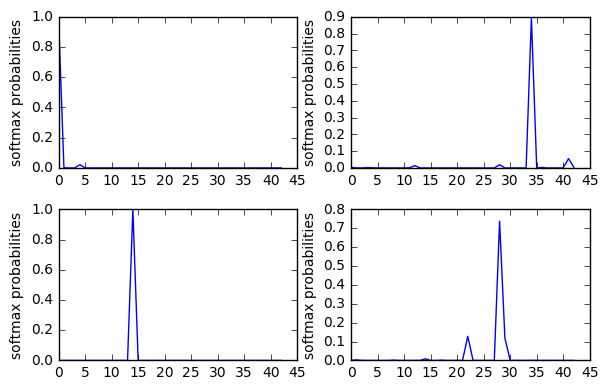

In [175]:
# visualize the softmax probabilities 
values, indices = tf.nn.top_k(predict_sm, k=42)
f, axarr = plt.subplots(2,2)
f.tight_layout()
for i in range(4):
    data = list(zip(indices[i].eval(), values[i].eval()))
    data=sorted(data)
    data = list(zip(*data))
    axarr[(i/2,i%2)].plot(list(data[0]),list(data[1]))
    axarr[(i/2,i%2)].set_ylabel("softmax probabilities")
   

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**
Save the pretrained model, and evaluate against newly captured web images and get 1-prediction or top-5 prediction.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.